# API access to CZIs too large for memory

We'd like to be able to access files that are too large to fit in RAM. We get these from long time lapses, acquisitions of many 3D fields, and other similarly intensive microscopy tasks. Previously we've only been able to access these files in Python by manually splitting them in the Zeiss ZEN gui. Let's see if we can't work around that limitation using `czifile`.

We'll first do the standard imports:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

And now we'll try to import `czifile`

In [3]:
import czifile

Looks like it works! Let's choose our giant file to try reading. 

In [4]:
#replace fn with the path to your own giant file
fn = '/Volumes/aics/assay-dev/MicroscopyData/Melissa/2018/20180211/20180211_M05_001.czi'

print("file exists: "+str(os.path.exists(fn)))
print("file is %0.1f gb in size"%(os.path.getsize(fn)/2**30))

file exists: True
file is 846.8 gb in size


Come loaded for bear, that's a big file. Can we access it?

In [5]:
czi = czifile.CziFile(fn)

The lack of errors is encouraging. Can we actually see an image from it?

CZIs are structured into subblocks for individual frames. Let's load a single subblock and print where it lies in the file's dimensional structure

In [6]:
#Subblocks returns an iterator, so we'll just take the first one
subb = next(czi.subblocks())
for dim in subb.dimension_entries:
    print("dim:start is %s:%i"%(str(dim.dimension), dim.start))

dim:start is b'M':0
dim:start is b'B':0
dim:start is b'S':0
dim:start is b'T':0
dim:start is b'C':0
dim:start is b'Z':0
dim:start is b'Y':19855
dim:start is b'X':167448


That's where we are. At the start of every dimension except x and y (which is the subject of its own confusing digression). Is there an image in this subblock?

(-0.5, 2047.5, 2047.5, -0.5)

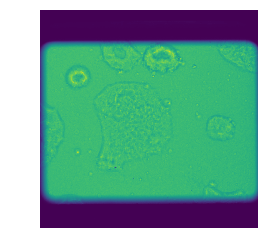

In [7]:
plt.imshow(np.squeeze(subb.data()))
plt.axis('off')

Looks like it. Can we look at a couple of those?

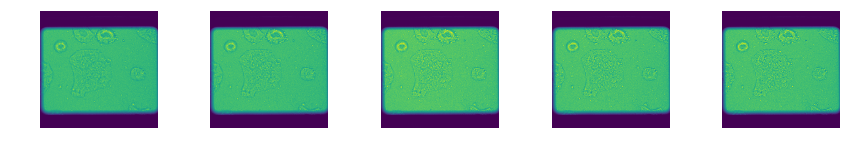

In [8]:
subblocks_iter = czi.subblocks()

fig, axes = plt.subplots(1,5,figsize=(12,6))
for ax in axes:
    ax.imshow(np.squeeze(next(subblocks_iter).data()))
    ax.axis('off')
plt.tight_layout()

Looks like we can get multiple images back. Are they actually different? Let's look farther into the stack. 

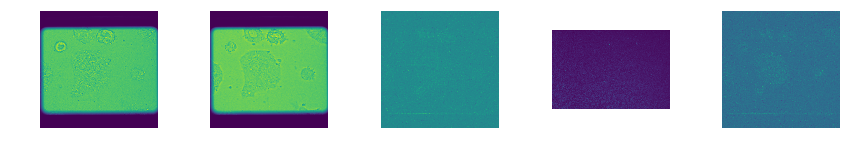

In [9]:
subblocks_iter = czi.subblocks()

fig, axes = plt.subplots(1,5,figsize=(12,6))
for ax in axes:
    [next(subblocks_iter) for i in range(10)]
    ax.imshow(np.squeeze(next(subblocks_iter).data()))
    ax.axis('off')
plt.tight_layout()

Def returning diff images. Now we can scan through the contents of our giant file without needing to load the whole thing directly into RAM. 